In [1]:
%matplotlib inline
import pandas as pd
import seaborn
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import randint, shuffle, choice

# Simulation based statistics with real life applications

Sources:

* [Talk by Jake VanderPlas](https://www.youtube.com/watch?v=Iq9DzN6mvYA)
* [Slides by Jake VanderPlas](https://speakerdeck.com/jakevdp/statistics-for-hackers)
* [RANDOM PERMUTATION TESTS](http://danielnee.com/2015/01/random-permutation-tests/)
* [Statistics Without the Agonizing Pain](https://www.youtube.com/watch?v=5Dnw46eC-0o)
* Book "Statistics is Easy" 2nd ed, Dennis Shasha and Manda Wilson


Might be usefull: [Fishers test](https://pypi.python.org/pypi/permutation_test/0.16)


Main methods covered in this notebook:

1. **Direct simulations**
2. **Shuffling**
3. **Bootstrapping**
4. **Cross Validation**

Real-life applications:

1. A/B Testing
2. ...



# Hypothesis testing: Coin toss

We will start with the simplest task possible - coin toss.

**TASK:** Coin tossed 17 times produced 2 tails. Is it fair?

## Classic Method

$$
P\left(N_{H},N_{T}\right)=\left(\begin{array}{c}
N_{H}+N_{T}\\
N_{H}
\end{array}\right)\left(\frac{1}{2}\right)^{N_{H}}\left(1-\frac{1}{2}\right)^{N_{T}}
$$

## Using direct simulation

We can solve this easily using direct simulation as follows.

In [2]:
n_exp = 10000000
data = np.sum(np.random.randint(0, 2, size=[17, n_exp]), axis=0)

/home/trokas/anaconda3/envs/ai_primer/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


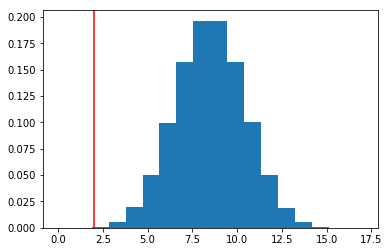

In [3]:
plt.hist(data, bins=18, normed = True)
plt.axvline(x = 2, color = 'red')
plt.show()

In [4]:
print('Probability according to simulation: {:.4%}'.format(np.mean(data == 2)))

Probability according to simulation: 0.1048%


Acctual probability is 0.103759765625%. Note that making more simulations yeld more reliable results than making multiple small simulations.

**Tip:** use numpy matrix to make calculations faster. For more complex simulations *numba* might be handy.

## Make pymc toss a coin

Let's cheat a bit and say that we don't know anything about coins.

In [5]:
data = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1]
toss = pm.Uniform('toss', lower=0, upper=1)
coin = pm.Bernoulli('coin', p=toss, value=data, observed=True)
mcmc = pm.MCMC([toss, coin])
mcmc.sample(50000, 1000)
plt.hist(mcmc.trace("toss")[:], bins = 20)
plt.show()

NameError: name 'pm' is not defined

# Shuffling: Placebo vs Drug

Lets say, that after performing experiment we obtained following measurements:

* Placebo: 54 51 58 44 55 52 42 47 58 46
* Drug: 54 73 53 70 73 68 52 65 65

**Problem:** is this drug useful?

What is probability that assigning labels on random will lead to such mean difference.

In [6]:
placebo = np.array([54,51,58,44,55,52,42,47,58,46])
drug = np.array([54,73,53,70,73,68,52,65,65])
data = np.append(placebo, drug)
p_len = placebo.shape[0]
expected = drug.mean() - placebo.mean()
print("Impact on means: {0}".format(expected))

Impact on means: 12.966666666666661


In [7]:
means = np.array([])
for _ in range(100000):
    permuted = np.random.permutation(data)
    means = np.append(means, permuted[p_len:].mean() - permuted[:p_len].mean())

/home/trokas/anaconda3/envs/ai_primer/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


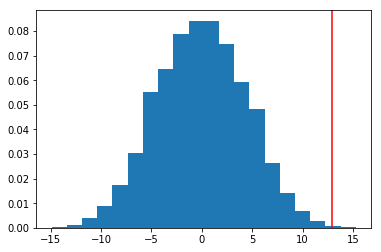

In [8]:
plt.hist(means, bins = 20, normed = True)
plt.axvline(x = expected, color = 'red')
plt.show()

In [9]:
print('Probability that this is due to random event: {:.4%}'.format(np.mean(means >= expected)))

Probability that this is due to random event: 0.0910%


This means that there is only 0.1% chance that such difference have been observed randomly.
Another example:
* Placebo 56 348 162 420 440 250 389 476 288 456 
* Drug +13

Impact on means: 13.0


/home/trokas/anaconda3/envs/ai_primer/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


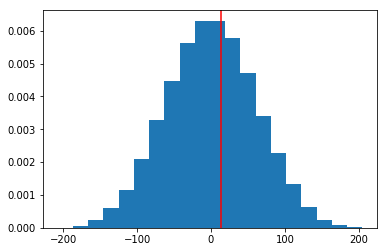

Probability that this is due to random event: 41.9310%


In [10]:
placebo = np.array([56,348,162,420,440,250,389,476,288,456])
drug = placebo + 13
data = np.append(placebo, drug)
p_len = placebo.shape[0]
expected = drug.mean() - placebo.mean()
print("Impact on means: {0}".format(expected))
means = np.array([])
for _ in range(100000):
    permuted = np.random.permutation(data)
    means = np.append(means, permuted[p_len:].mean() - permuted[:p_len].mean())
plt.hist(means, bins = 20, normed = True)
plt.axvline(x = expected, color = 'red')
plt.show()
print('Probability that this is due to random event: {:.4%}'.format(np.mean(means >= expected)))

Note that **Significance** does not tell about **effect**!

# A/B Testing

Let's say that we have following obervations:

* In target group 20 customers churned from 500.
* In control group 70 customers churned from 1000.

Is this significant impact?

Shuffling might be usefull in this case.

Impact on churn rate: -0.030000000000000006


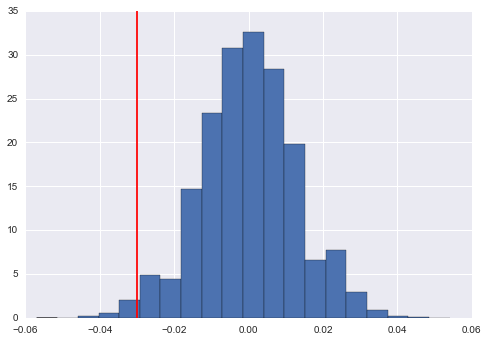

Probability that this is due to random event: 0.8540%


In [51]:
target = np.append(np.zeros(480), np.ones(20))
control = np.append(np.zeros(930), np.ones(70))
data = np.append(target, control)
split = target.shape[0]
expected = np.sum(target)/target.shape[0] - np.sum(control)/control.shape[0]
print("Impact on churn rate: {0}".format(expected))
rates = np.array([])
for _ in range(100000):
    permuted = np.random.permutation(data)
    rates = np.append(rates, np.sum(permuted[split:])/permuted[split:].shape[0] - np.sum(permuted[:split])/split)
plt.hist(rates, bins = 20, normed = True)
plt.axvline(x = expected, color = 'red')
plt.show()
print('Probability that this is due to random event: {:.4%}'.format(np.mean(rates < expected)))

## A little bit of bayes

In [52]:
import pymc as pm

In [53]:
target_conv = pm.Uniform('target_conv', lower=0, upper=1)
control_conv = pm.Uniform('control_conv', lower=0, upper=1)

@pm.deterministic
def delta(target_conv=target_conv, control_conv=control_conv):
    return control_conv - target_conv

target_obs = pm.Bernoulli("target_obs", target_conv, value = target, observed = True)
control_obs = pm.Bernoulli("control_obs", control_conv, value = control, observed = True)

mcmc = pm.MCMC([target_conv, control_conv, delta, target_obs, control_obs])
mcmc.sample(50000, 1000)

 [-----------------100%-----------------] 50000 of 50000 complete in 4.7 sec

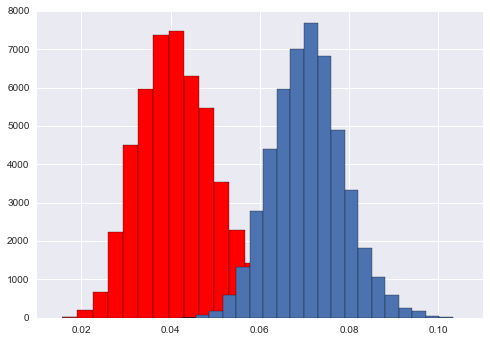

In [54]:
plt.hist(mcmc.trace("target_conv")[:], bins = 20, color = 'red')
plt.hist(mcmc.trace("control_conv")[:], bins = 20)
plt.show()

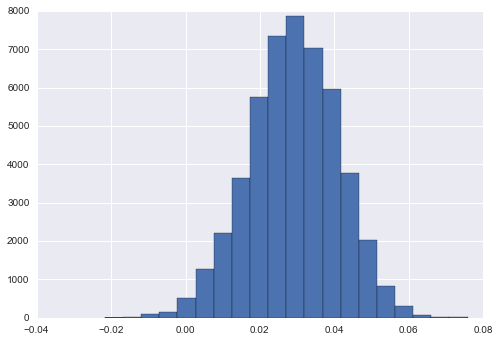

In [55]:
plt.hist(mcmc.trace("delta")[:], bins = 20)
plt.show()

In [56]:
np.mean(mcmc.trace("delta")[:] < 0)

0.0098163265306122453

Let's see what happens if we take smaller numbers.

Impact on churn rate: -0.003


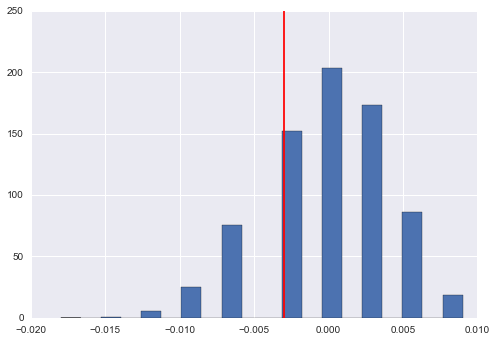

Probability that this is due to random event: 14.4180%


In [57]:
target = np.append(np.zeros(498), np.ones(2))
control = np.append(np.zeros(993), np.ones(7))
data = np.append(target, control)
split = target.shape[0]
expected = np.sum(target)/target.shape[0] - np.sum(control)/control.shape[0]
print("Impact on churn rate: {0}".format(expected))
rates = np.array([])
for _ in range(100000):
    permuted = np.random.permutation(data)
    rates = np.append(rates, np.sum(permuted[split:])/permuted[split:].shape[0] - np.sum(permuted[:split])/split)
plt.hist(rates, bins = 20, normed = True)
plt.axvline(x = expected, color = 'red')
plt.show()
print('Probability that this is due to random event: {:.4%}'.format(np.mean(rates < expected)))

 [-----------------100%-----------------] 50000 of 50000 complete in 4.3 sec

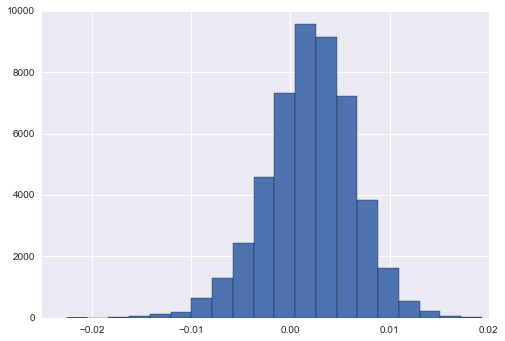

0.296653061224


In [58]:
target_conv = pm.Uniform('target_conv', lower=0, upper=1)
control_conv = pm.Uniform('control_conv', lower=0, upper=1)
@pm.deterministic
def delta(target_conv=target_conv, control_conv=control_conv):
    return control_conv - target_conv
target_obs = pm.Bernoulli("target_obs", target_conv, value = target, observed = True)
control_obs = pm.Bernoulli("control_obs", control_conv, value = control, observed = True)
mcmc = pm.MCMC([target_conv, control_conv, delta, target_obs, control_obs])
mcmc.sample(50000, 1000)
plt.hist(mcmc.trace("delta")[:], bins = 20)
plt.show()
print(np.mean(mcmc.trace("delta")[:] < 0))

It is easy to see that shuffling yelds same results as pymc, but it takes longer to perform simulations and results are less reliable. **Note that red line resembles zero in pyms plots.**

# Boostrapping

“What is the 90% confidence interval of difference in the averages
between the drug patients and placebo?”

Bootstrapping - simulate distribution by drawing random samples with replacement.

In [130]:
df = pd.DataFrame()
df['score'] = [54,51,58,44,55,52,42,47,58,46,54,73,53,70,73,68,52,65,65]
df['label'] = ['D' if s<10 else 'P' for s in range(19)]

In [ ]:
evaluation = pd.DataFrame()
evaluation['rand'] = np.array([choice(df[df.label == 'P']['score'].values, 10).mean() - 
        choice(df[df.label == 'D']['score'].values, 10).mean() for _ in range(10000)])

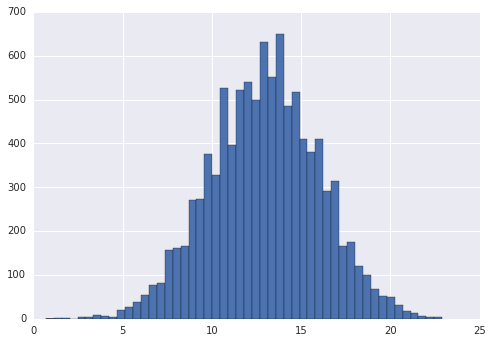

In [139]:
evaluation['rand'].hist(bins = 50)

In [143]:
evaluation['rand'].quantile([0.05, 0.95])

0.05     7.9
0.95    18.0
Name: rand, dtype: float64

This means that 90% of the time Drug will give average value higher than Placebo in range 7.9, 18.

Next example consists of incomes.

In [156]:
df = pd.DataFrame()
df['incomes'] = [200,69,141,45,154,169,142,198,178,197,1000000,166,188,178,129,87,151,101,187,154]

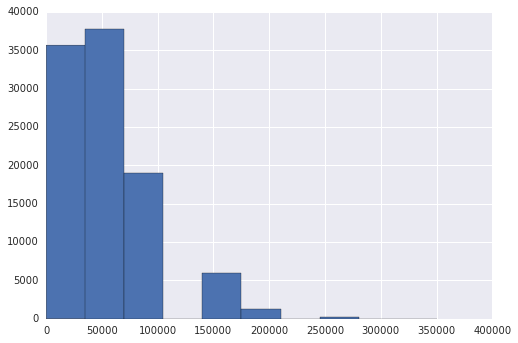

In [159]:
evaluation = pd.DataFrame()
evaluation['rand'] = np.array([choice(df['incomes'].values, df.shape[0]).mean() for _ in range(100000)])
evaluation['rand'].hist()

In [160]:
evaluation['rand'].quantile([0.05, 0.95])

0.05       138.45
0.95    150125.90
Name: rand, dtype: float64

Note that this is a huge range of values, thus we can say that average is uninformative in such case!

If you’ve been following this carefully, you might now wonder “If I have a confidence interval,
what more does significance bring to the party?” To answer this intuitively, consider a simple
example in which you have just one element of group A having value 50 and one element of group
B having value 40. The confidence interval using replacement will say that the difference is always 10. 
But intuitively this is way too little data. The significance test (in which one permutes the group
labels) will show that half the time one will get, just by random chance, a difference as big as the
observed one. 

## Cross validation

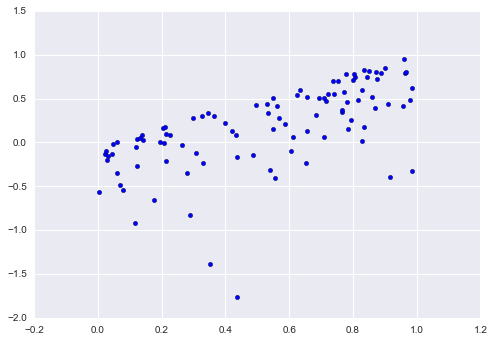

In [92]:
x = np.random.rand(100)
y = x + np.log(np.random.rand(100))/3
plt.scatter(x,y)
plt.show()

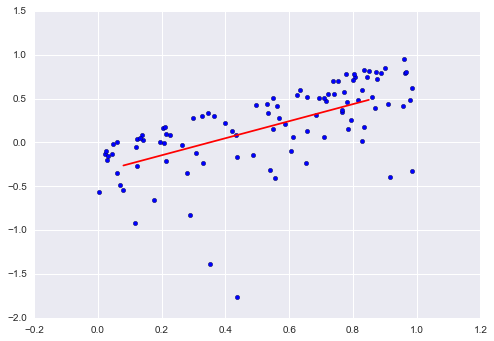

In [96]:
f = np.poly1d(np.polyfit(x, y, 1))
x_line = np.linspace(x[0], x[-1], 50)
y_line = f(x_line)
plt.scatter(x,y)
plt.plot(x_line, y_line, color = 'red')
plt.show()